# Vizualization of adversarial examples for different norms

In [ ]:
import os
os.chdir("../")
import sys
import json
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import foolbox
import scipy.io as io
from argparse import Namespace
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper')

from utils import L1, L2, NumpyEncoder
from provable_robustness_max_linear_regions import data as dt
from provable_robustness_max_linear_regions import models
from utils import NumpyEncoder

## Plot settings:

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text', usetex=True)

# dictionary that maps color string to 'good looking' seaborn colors that are easily distinguishable
colors = {
    "orange": sns.xkcd_rgb["yellowish orange"],
    "red": sns.xkcd_rgb["pale red"],
    "green": sns.xkcd_rgb["medium green"],
    "blue": sns.xkcd_rgb["denim blue"],
    "yellow": sns.xkcd_rgb["amber"],
    "purple": sns.xkcd_rgb["dusty purple"],
    "cyan": sns.xkcd_rgb["cyan"]
}

## Calculate adversarials:

Estimated runtime (if no file with data is present): < 1 hour

In [3]:
def save_to_json(dictionary, file_name):
        
    if not os.path.exists("res"):
        os.makedirs("res")

    with open("res/" + file_name + ".json", 'w') as fp:
        json.dump(dictionary, fp, cls = NumpyEncoder)
        
def load_from_json(file_name):

    if not os.path.exists("res/" + file_name + ".json"):
        return None
    else:
        with open("res/" + file_name + ".json", 'r') as fp:
            loaded_json =  json.load(fp)

    return loaded_json

def load_model(sess, args, model_path):
    
    _input = tf.placeholder(tf.float32, (1 , args.height, args.width, args.n_col))
    input_expanded = tf.expand_dims(_input, axis=0)
    
    model = models.LeNetSmall(False, args, args.dataset)
    _logits = model.net(input_expanded)[-1]
    _activations = model.net(input_expanded)

    param_file = io.loadmat(model_path)

    weight_names = ['weights_conv1', 'weights_conv2', 'weights_fc1', 'weights_fc2']
    bias_names = ['biases_conv1', 'biases_conv2', 'biases_fc1', 'biases_fc2']


    for var_tf, var_name_mat in zip(model.W, weight_names):
        var_tf.load(param_file[var_name_mat], sess)
    for var_tf, var_name_mat in zip(model.b, bias_names):
        bias_val = param_file[var_name_mat]
        bias_val = bias_val.flatten()
        var_tf.load(bias_val, sess)
            
    return model, _input, _logits, _activations

model_paths = [ "provable_robustness_max_linear_regions/models/plain/2019-02-19 01:20:16 dataset=gts nn_type=cnn_lenet_small p_norm=inf lmbd=0.0 gamma_rb=0.0 gamma_db=0.0 ae_frac=0.0 epoch=100.mat", "provable_robustness_max_linear_regions/models/mmr+at/2019-02-17 23:43:21 dataset=gts nn_type=cnn_lenet_small p_norm=inf lmbd=1.0 gamma_rb=6.0 gamma_db=6.0 ae_frac=0.5 epoch=100.mat", "provable_robustness_max_linear_regions/models/mmr+at/2019-02-24 17:53:14 dataset=gts nn_type=cnn_lenet_small p_norm=2 lmbd=6.0 gamma_rb=0.3 gamma_db=0.3 ae_frac=0.5 lr=0.001 epoch=100.mat"]
dataset="gts"

adversarials = load_from_json("adversarials_for_visualization_dataset=gts")

if not adversarials:
    
    adversarials = dict()
    
    for model_path in model_paths:

        model_name = model_path.split("/")[3].split(".")[0]
        
        adversarials[model_name] = dict()

        _, x_test, _, y_test = dt.get_dataset(dataset)

        args = Namespace()
        n_test_ex, args.height, args.width, args.n_col = x_test.shape
        args.n_in, args.n_out = args.height * args.width * args.n_col, y_test.shape[1]
        args.n_hs = []
        args.seed = 1
        args.dataset = dataset

        sess = tf.InteractiveSession()

        model, _input, _logits, _activations = load_model(sess, args, model_path)

        f_model = foolbox.models.TensorFlowModel(_input,_logits, (0, 1))

        x_sample = x_test[:5]
        y_sample = y_test[:5] 

        adversarials[model_name]["points"] = x_sample
        adversarials[model_name]["labels"] = y_sample

        test_predictions = []
        for point in x_sample:

            if dataset == "gts" or dataset == "cifar10":
                point = point.reshape(1,32,32,3)
            else:
                point = point.reshape(1,28,28,1)

            test_predictions.append(f_model.forward(point).argmax())

        test_predictions = np.array(test_predictions)

        attack = foolbox.attacks.ProjectedGradientDescentAttack(model = f_model, criterion = foolbox.criteria.Misclassification(), distance = foolbox.distances.Linf)

        adversarials[model_name]["inf"] = []
        for i, point in enumerate(x_sample):

            if dataset == "gts" or dataset == "cifar10":
                point = point.reshape(1,32,32,3)
            else:
                point = point.reshape(1,28,28,1)

            adversarials[model_name]["inf"].append(attack(point, np.array([y_sample[i].argmax()])))

        adversarials[model_name]["inf"] = np.array(adversarials[model_name]["inf"])

        attack = foolbox.attacks.CarliniWagnerL2Attack(model = f_model, criterion = foolbox.criteria.Misclassification(), distance = L2)

        adversarials[model_name]["2"] = []
        for i, point in enumerate(x_sample):

            if dataset == "gts" or dataset == "cifar10":
                point = point.reshape(1,32,32,3)
            else:
                point = point.reshape(1,28,28,1)

            adversarials[model_name]["2"].append(attack(point, np.array([y_sample[i].argmax()])))

        adversarials[model_name]["2"] = np.array(adversarials[model_name]["2"])

        attack = foolbox.attacks.EADAttack(model = f_model, criterion = foolbox.criteria.Misclassification(), distance = L1)

        adversarials[model_name]["1"] = []
        for i, point in enumerate(x_sample):

            if dataset == "gts" or dataset == "cifar10":
                point = point.reshape(1,32,32,3)
            else:
                point = point.reshape(1,28,28,1)

            adversarials[model_name]["1"].append(attack(point, np.array([y_sample[i].argmax()])))

        adversarials[model_name]["1"] = np.array(adversarials[model_name]["1"])
        
        sess.close()
        tf.reset_default_graph()

    save_to_json(adversarials, "adversarials_for_visualization_dataset=gts")

## Plot:

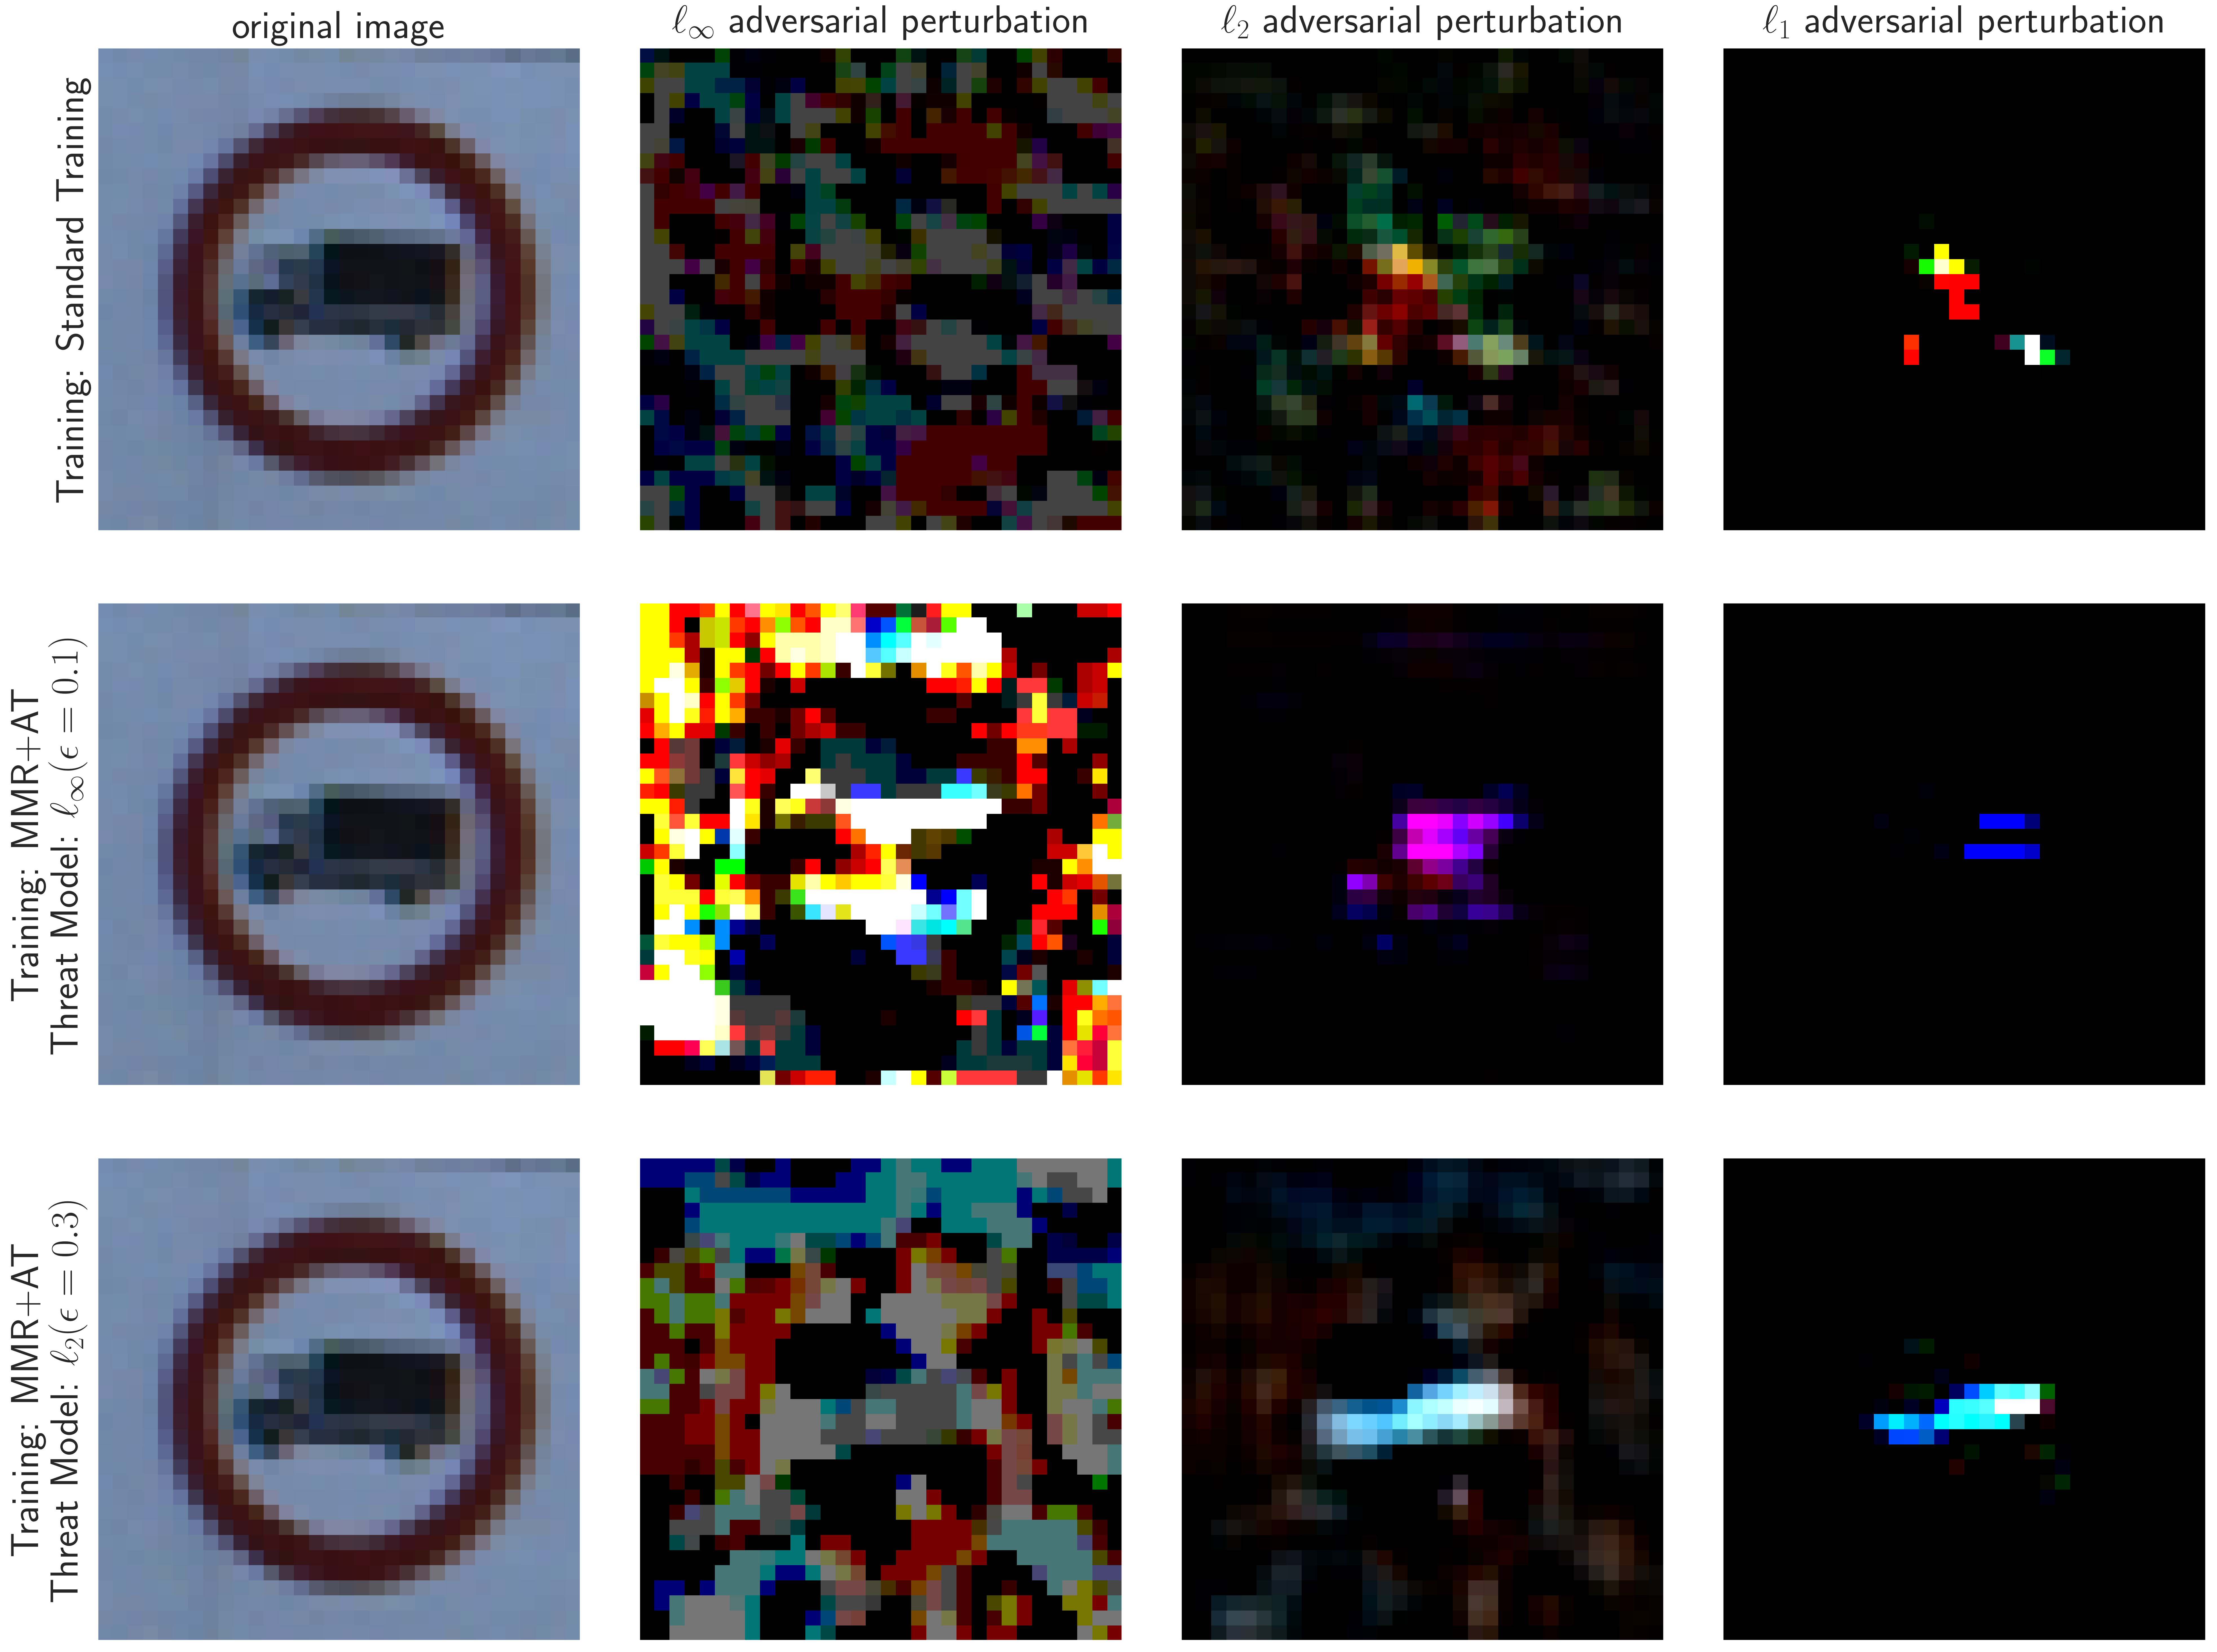

In [4]:
# name to save the plot
save_name = "fig_adversarials_visualized_3"

# number of model types and parameter combinations
n_cols = 4
n_rows = 3

fig, ax = plt.subplots(n_rows, n_cols, figsize = (5 * n_cols, 5 * n_rows), dpi=400)

for i, model_path in enumerate(model_paths):

    model_name = model_path.split("/")[3].split(".")[0]
        
    x_sample = np.array(adversarials[model_name]["points"])

    sample = x_sample[0]
    ax[i][0].imshow(sample)
    ax[i][0].get_xaxis().set_ticks([])
    ax[i][0].get_yaxis().set_ticks([])
    ax[i][0].get_xaxis().set_ticklabels([])
    ax[i][0].get_yaxis().set_ticklabels([])

    for j, norm in enumerate(["inf", "2", "1"]):
        difference = np.clip((np.array(adversarials[model_name][norm][0]).reshape(32,32,3) - sample) * 10.0, 0.0, 1.0)
        ax[i][j+1].imshow(difference)
        ax[i][j+1].get_xaxis().set_ticks([])
        ax[i][j+1].get_yaxis().set_ticks([])
        ax[i][j+1].get_xaxis().set_ticklabels([])
        ax[i][j+1].get_yaxis().set_ticklabels([])


ax[0][0].set_title("original image", fontsize=25)
ax[0][1].set_title("$\ell_\infty$ adversarial perturbation", fontsize=25)
ax[0][2].set_title("$\ell_2$ adversarial perturbation", fontsize=25)
ax[0][3].set_title("$\ell_1$ adversarial perturbation", fontsize=25)

ax[0][0].set_ylabel("Training: Standard Training", fontsize=25)
ax[1][0].set_ylabel("Training: MMR+AT\nThreat Model: $\ell_\infty(\epsilon=0.1)$", fontsize=25)
ax[2][0].set_ylabel("Training: MMR+AT\nThreat Model: $\ell_2(\epsilon=0.3)$", fontsize=25)

fig.tight_layout()
fig.savefig('res/{}.pdf'.format(save_name))